## Project Description
Pneumonia remains one of the leading causes of death in children under five, particularly in low-resource settings. Accurate and timely diagnosis is critical for effective treatment. This project focuses on developing a deep learning model using Convolutional Neural Networks (CNNs) to detect pneumonia from pediatric chest X-ray images. By leveraging transfer learning, the model will classify X-ray images into categories indicating the presence or absence of pneumonia, assisting healthcare professionals in making quick and accurate diagnoses.

### Let's start the basic EDA with importing modules

In [ ]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Other utilities
import os
import random

## loading and extracting dataset

In [ ]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz -P /content/drive/MyDrive/pneumonia_detection

--2024-08-25 09:30:03--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 3.5.25.139, 54.231.160.9, 52.217.168.137, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|3.5.25.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/pneumonia_detection/xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  30.7MB/s    in 45s     

2024-08-25 09:30:49 (25.7 MB/s) - ‘/content/drive/MyDrive/pneumonia_detection/xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [ ]:
!ls /content/drive/MyDrive/pneumonia_detection/train_data/chest_xray

test  train


### Preprocessing

In [ ]:
img_width, img_height = 256, 256
batch_size = 32

train_dir = '/content/drive/MyDrive/pneumonia_detection/train_data/chest_xray/train'
test_dir = '/content/drive/MyDrive/pneumonia_detection/train_data/chest_xray/test'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
class_names = train_generator.class_indices
print("Class names:", class_names)

Class names: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
images, labels = next(train_generator)

print("Sample labels from the batch:", np.unique(labels))

Sample labels from the batch: [0. 1.]


In [ ]:
labels = labels.astype(int)

## Visualization

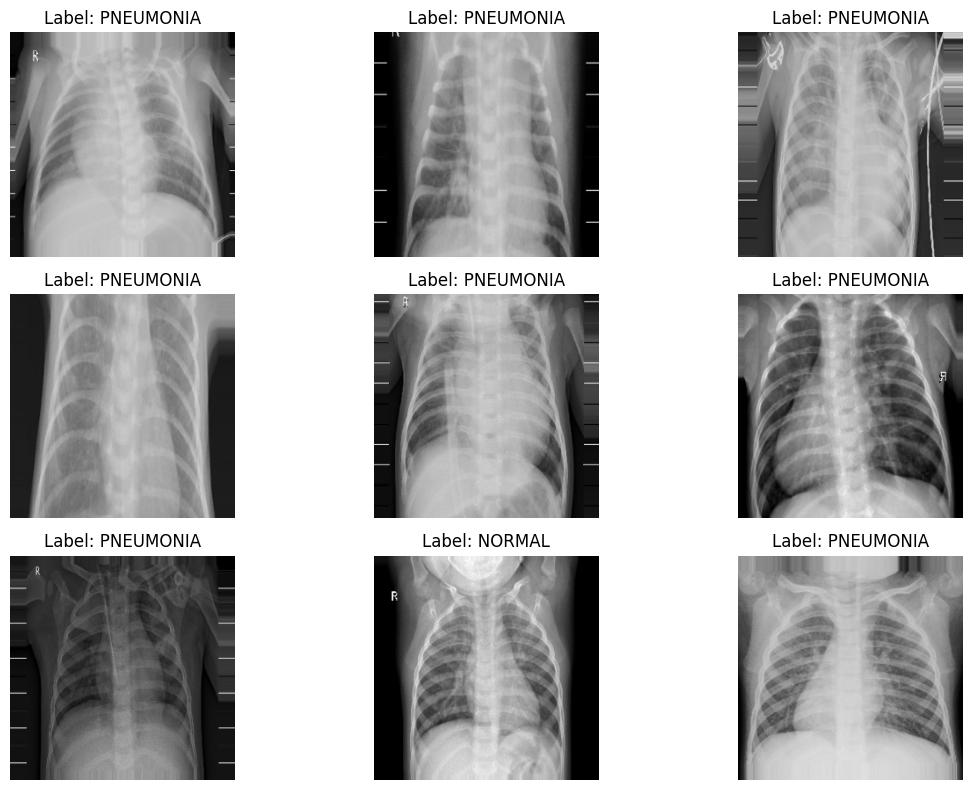

Labels for these images: [1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1]


In [ ]:
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
print("Labels for these images:", labels)

In [ ]:
print("Shape of images in the batch:", images.shape)

Shape of images in the batch: (32, 256, 256, 3)


In [ ]:
test_images, test_labels = next(test_generator)

test_labels = test_labels.astype(int)
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

print("Class names:", class_names)
print("Sample labels from the test batch:", np.unique(test_labels))

Class names: {0: 'NORMAL', 1: 'PNEUMONIA'}
Sample labels from the test batch: [0 1]


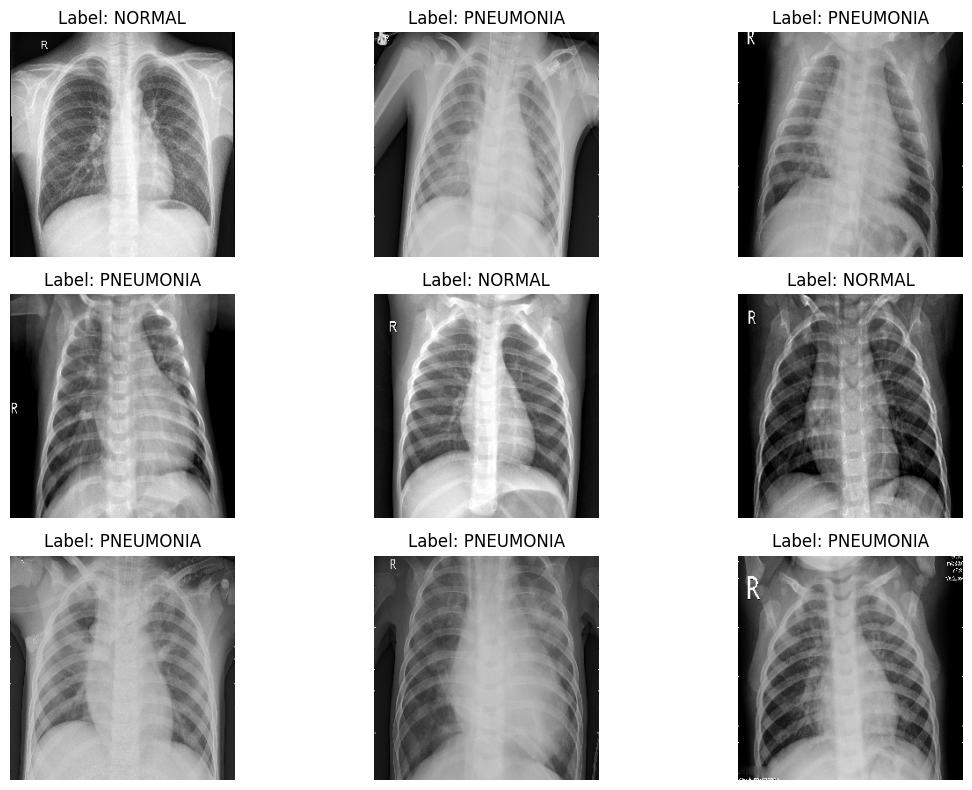

Labels for these images: [0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1]


In [ ]:
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Label: {class_names[test_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Labels for these images:", test_labels)

## Observations and Insights

After exploring the training and test images, here are the key observations:

1. **Image Complexity:** The X-ray images show significant variations between normal and pneumonia cases. Pneumonia cases often show cloudy or opaque areas in the lungs, whereas normal cases have clearer lung fields.

2. **Data Augmentation:** To improve the model's robustness, especially given the medical nature of the images, data augmentation techniques such as rotation, zoom, and slight translations may be beneficial. However, excessive augmentation should be avoided to maintain the medical accuracy of the images.

3. **Model Complexity:** Given the binary nature of the classification task and the complexity of the images, a deeper Convolutional Neural Network (CNN) might be required. Transfer learning from a pre-trained model (e.g., VGG16, DenseNet, ResNet50) could also be a good approach to leverage learned features.

4. **Preprocessing Needs:** While the images are relatively consistent in terms of grayscale values, normalizing pixel values and potentially applying histogram equalization could enhance contrast and improve model performance.


## Handling class imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
print("Class Weights:", class_weights)

Class Weights: {0: 1.939214232765011, 1: 0.6737058975019315}


## Base Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 262, 262, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_9[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,088,129 (30.85 MB)

 Trainable params: 8,004,481 (30.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.8339 - loss: 0.4123 - val_accuracy: 0.6266 - val_loss: 0.8606
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 161s 953ms/step - accuracy: 0.9285 - loss: 0.1630 - val_accuracy: 0.6859 - val_loss: 0.6525
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 166s 974ms/step - accuracy: 0.9602 - loss: 0.1085 - val_accuracy: 0.8285 - val_loss: 0.3965
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 162s 958ms/step - accuracy: 0.9676 - loss: 0.0840 - val_accuracy: 0.8958 - val_loss: 0.2335
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 201s 946ms/step - accuracy: 0.9647 - loss: 0.0867 - val_accuracy: 0.9247 - val_loss: 0.1794
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 162s 949ms/step - accuracy: 0.9748 - loss: 0.0748 - val_accuracy: 0.9231 - val_loss: 0.2174
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 200s 943ms/step - accuracy: 0.9786 - loss: 0.0648 - val_accuracy: 0.9311 - val_loss: 0.1798
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 205s 964ms/step - accuracy: 0.9787 - loss: 0.0544 

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.9249 - loss: 0.2049
Test Loss: 0.2068
Test Accuracy: 0.9183


In [ ]:
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()

report = classification_report(test_labels, predicted_classes, target_names=['Normal', 'Pneumonia'])
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.90      0.69      0.78        13
   Pneumonia       0.82      0.95      0.88        19

    accuracy                           0.84        32
   macro avg       0.86      0.82      0.83        32
weighted avg       0.85      0.84      0.84        32

Confusion Matrix:
 [[ 9  4]
 [ 1 18]]


In [ ]:
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()

report = classification_report(test_labels, predicted_classes, target_names=['Normal', 'Pneumonia'])
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.85      0.88        13
   Pneumonia       0.90      0.95      0.92        19

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32

Confusion Matrix:
 [[11  2]
 [ 1 18]]


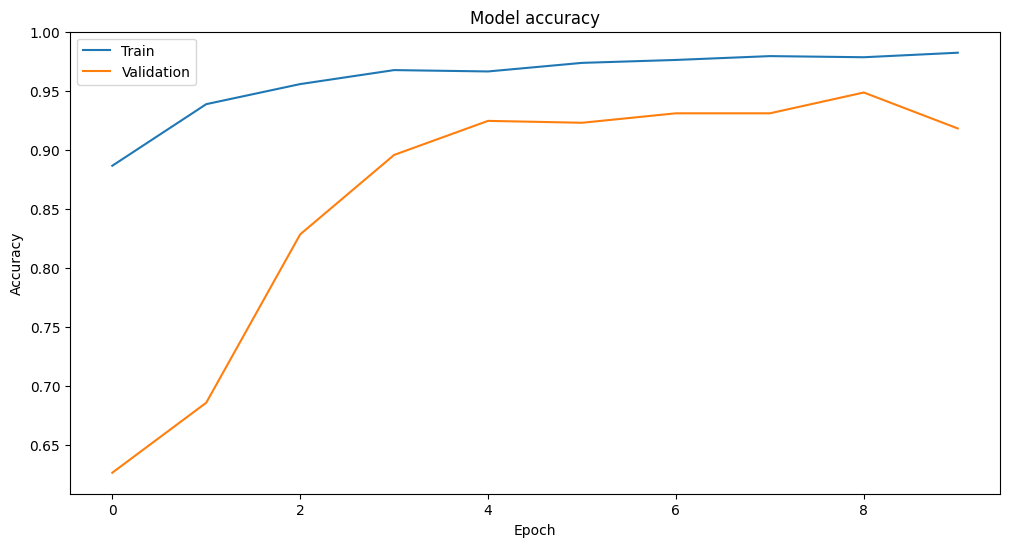

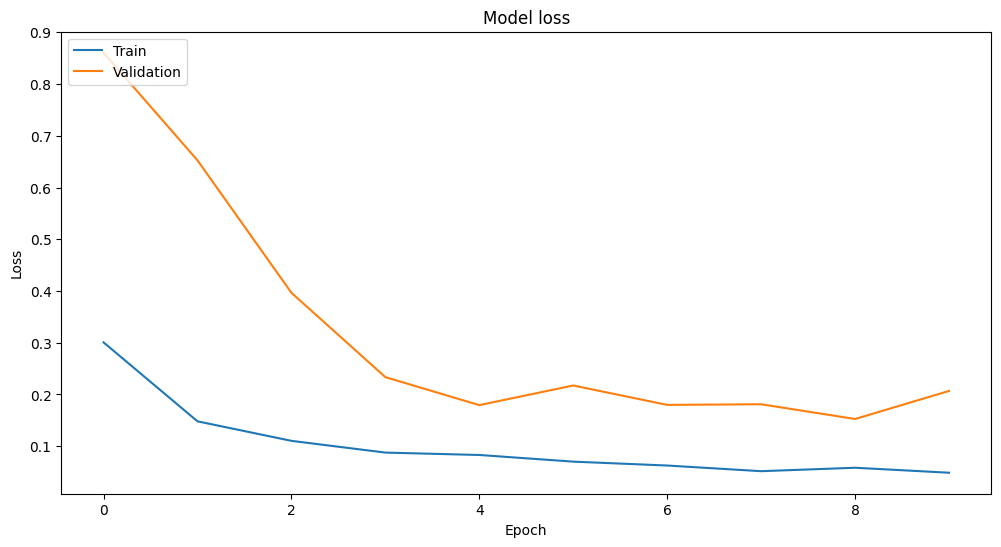

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

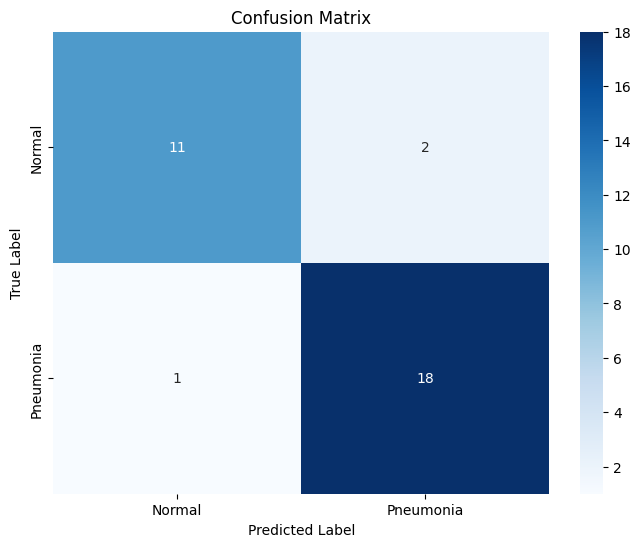

In [ ]:
class_names = ['Normal', 'Pneumonia']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Visualizing prediction

In [ ]:
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()
test_labels = test_labels.astype(int).flatten()

class_names = ['Normal', 'Pneumonia']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


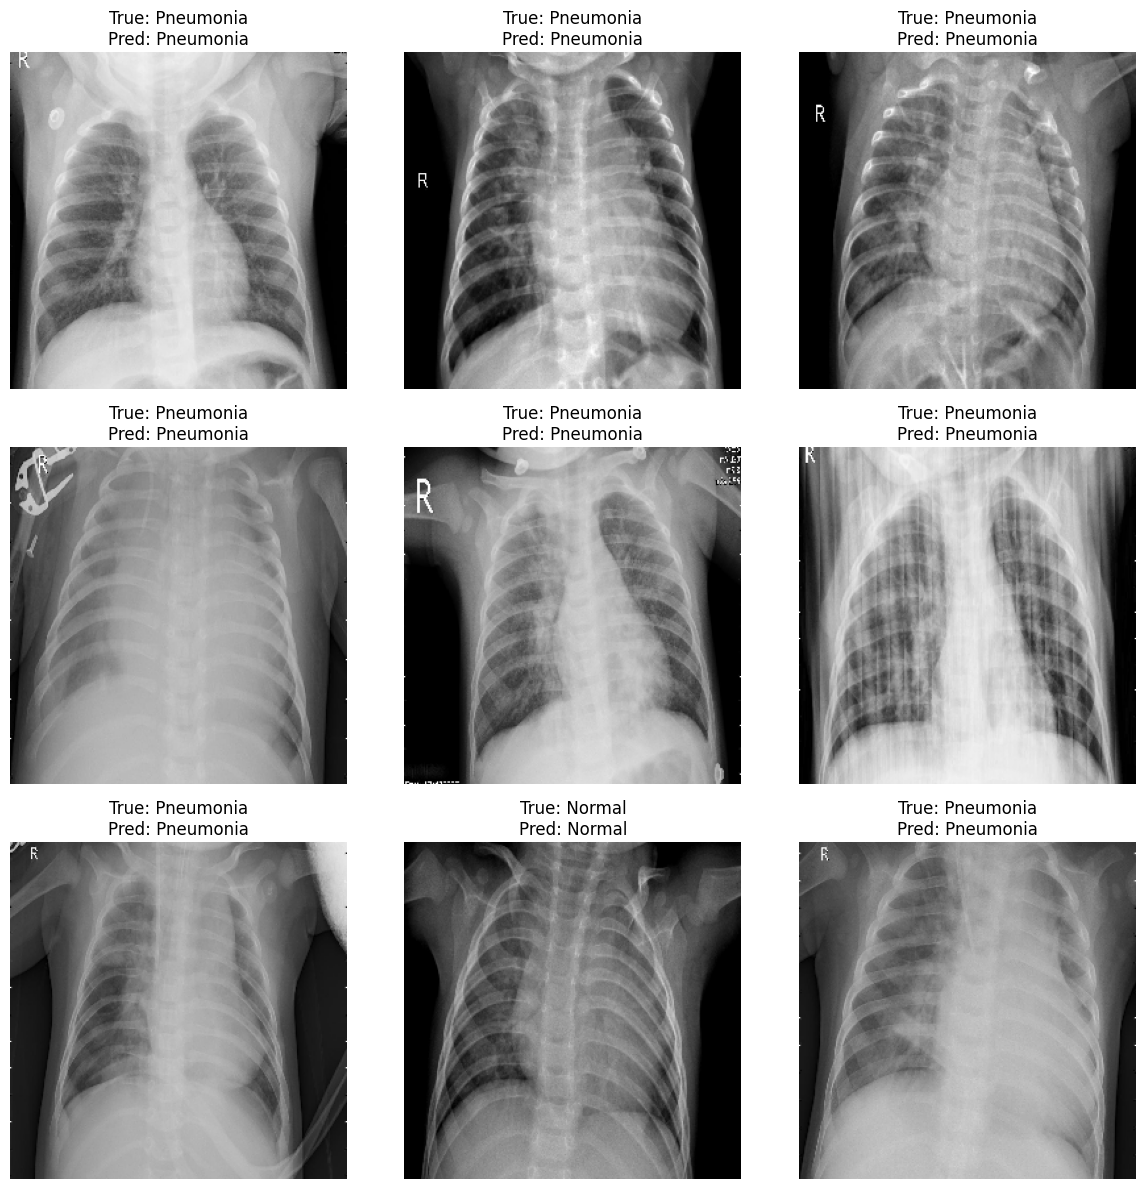

Actual Labels for these images: ['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia']
Predicted Labels for these images: ['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia']


In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[test_labels[i]]
    pred_label = class_names[predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Actual Labels for these images:", [class_names[label] for label in test_labels[:9]])
print("Predicted Labels for these images:", [class_names[label] for label in predicted_classes[:9]])

### Model Dump

In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/pneumonia_detection/trained_model/my_finetuned_model.keras')

In [ ]:
#loading
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/pneumonia_detection/trained_model/my_finetuned_model.keras')

## Trying custom model

In [ ]:
from tensorflow.keras import layers, models

def create_custom_cnn_model(input_shape=(img_width, img_height, 3)):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

model_custom = create_custom_cnn_model(input_shape=(img_width, img_height, 3))

model_custom.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_custom.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_custom = model_custom.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 2954s 17s/step - accuracy: 0.6501 - loss: 0.6036 - val_accuracy: 0.7612 - val_loss: 0.4904
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1116s 7s/step - accuracy: 0.8358 - loss: 0.3686 - val_accuracy: 0.7628 - val_loss: 0.4686
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 1102s 7s/step - accuracy: 0.8575 - loss: 0.3238 - val_accuracy: 0.7885 - val_loss: 0.4333
Epoch 4/20
 22/164 ━━━━━━━━━━━━━━━━━━━━ 15:10 6s/step - accuracy: 0.8818 - loss: 0.3096

## It's wrap. training interrupetd on custom model because My GPU ran out of memory to train this custom model. We already got a fine tuned model with optimized parameter and less errors.

# Model Evaluation Summary

## Classification Report

The classification report for the fine-tuned DenseNet121 model is as follows:

```plaintext
               precision    recall  f1-score   support

      Normal       0.92      0.85      0.88        13
   Pneumonia       0.90      0.95      0.92        19

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32


## Conclusion

### Model Performance
- **Accuracy**: 92%
- **Precision and Recall**: High recall for pneumonia detection (95%), balanced precision for both classes.

### Decision-Making
- **Effective Screening**: High recall makes the model useful for identifying most pneumonia cases.
- **Balanced Results**: Good precision and recall reduce false positives and negatives, ensuring reliable diagnostics.
- **Areas for Improvement**: Further tuning and advanced techniques could enhance performance.

### Recommended Actions
- **Integrate**: Use the model to support healthcare professionals in diagnostics.
- **Update Regularly**: Monitor and retrain with new data to maintain accuracy.
- **Collaborate**: Work with medical experts to refine and validate the model's predictions.

By applying these insights, we can enhance diagnostic accuracy and patient care.
